In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
from sklearn import preprocessing
from sklearn import model_selection
from scikeras.wrappers import KerasRegressor
from Data_mining import data_mining

In [2]:
#Data mining process
#df=data_mining("ETH-USDT", "5m", "2021/01/01", "2023/08/08")
#df.to_csv("ETH-USDT_5m.csv")
#df

In [3]:
df=pd.read_csv('./ETH-USDT_5m.csv')
df=df.set_index(['time'])
df

,open,close,high,low,volume
time,,,,,
2021-01-01 00:00:00,738.52,739.09,739.09,737.71,9102.55
2021-01-01 00:05:00,739.09,739.65,740.49,738.83,9580.63
2021-01-01 00:10:00,739.65,739.18,740.11,738.98,8915.66
2021-01-01 00:15:00,739.18,739.07,739.87,738.75,8787.57
2021-01-01 00:20:00,739.10,741.32,741.51,738.94,9586.71
...,...,...,...,...,...
2023-08-03 23:35:00,1848.18,1847.14,1848.18,1846.79,996.34
2023-08-03 23:40:00,1847.14,1848.78,1849.06,1846.67,1199.76
2023-08-03 23:45:00,1848.78,1849.41,1849.41,1848.26,937.50


In [4]:
pd.date_range(start='2021-01-01 00:00:00', end='2023-08-03 23:55:00').difference(df.index)

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

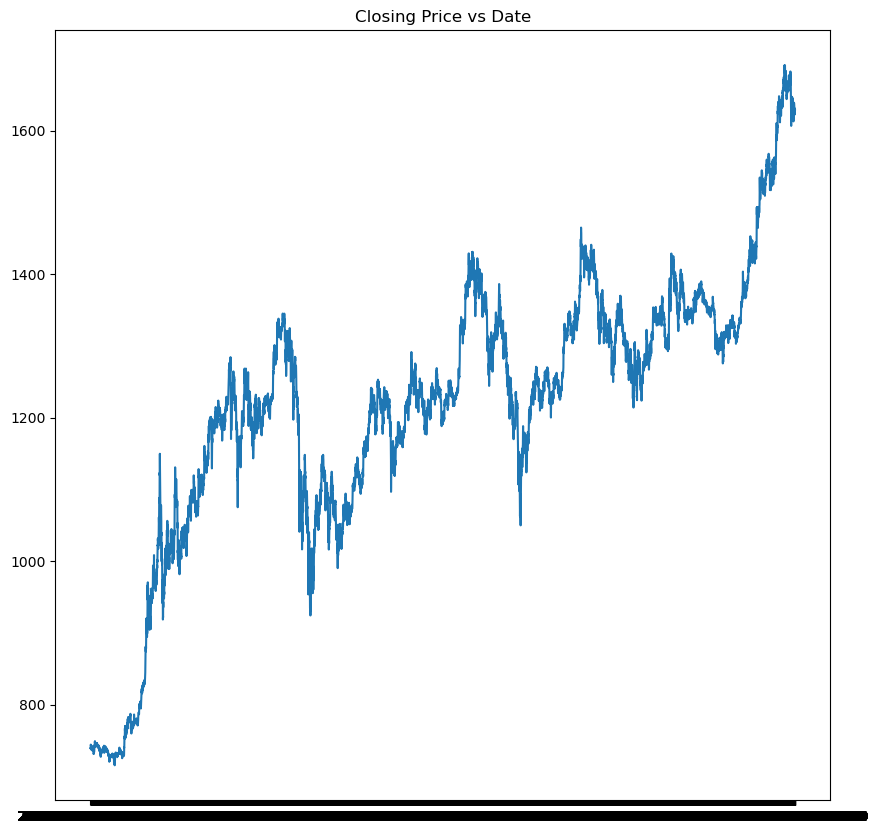

In [5]:
plt.figure(figsize=(10,10))
plt.title("Closing Price vs Date")
plt.plot(df['close'][0:10000])
plt.show()

In [6]:
dataset=df.iloc[:, 0:df.shape[1]].values
dataset.shape

(272443, 5)

In [7]:
scaler=preprocessing.MinMaxScaler(feature_range=(0, 1))
dataset_scaled=scaler.fit_transform(dataset)

In [8]:
dataset_scaled.shape

(272443, 5)

In [9]:
dataset_scaled

array([[0.00551431, 0.00574165, 0.0046863 , 0.00553717, 0.01496905],
       [0.00565175, 0.00587669, 0.00502396, 0.0058081 , 0.01575525],
       [0.00578677, 0.00576336, 0.00493231, 0.00584439, 0.01466171],
       ...,
       [0.2732152 , 0.27348929, 0.27248301, 0.27418309, 0.00154171],
       [0.27336711, 0.2738293 , 0.27282309, 0.27445886, 0.00248543],
       [0.27370708, 0.27407768, 0.27317764, 0.27480236, 0.00235723]])

In [10]:
training_set, test_and_validation_set=model_selection.train_test_split(dataset_scaled, test_size=0.02, shuffle=False)
training_set.shape

(266994, 5)

In [11]:
test_and_validation_set.shape

(5449, 5)

In [12]:
validation_set, test_set=model_selection.train_test_split(test_and_validation_set, test_size=0.5, shuffle=False)
print(validation_set.shape)
print(test_set.shape)

(2724, 5)
(2725, 5)


In [13]:
X_train=[]
y_train=[]
for i in range(12, len(training_set)):
    X_train.append(training_set[i-12:i, :])
    y_train.append(training_set[i, 1])
X_train, y_train=np.array(X_train), np.array(y_train)

In [14]:
X_train=np.reshape(X_train, newshape=(X_train.shape[0], X_train.shape[1], df.shape[1]))
X_train.shape

(266982, 12, 5)

In [15]:
y_train.shape

(266982,)

In [16]:
X_validation=[]
y_validation=[]
for i in range(12, len(validation_set)):
    X_validation.append(validation_set[i-12:i, :])
    y_validation.append(validation_set[i, 1])
X_validation, y_validation=np.array(X_validation), np.array(y_validation)
X_validation=np.reshape(X_validation, newshape=(X_validation.shape[0], X_validation.shape[1], df.shape[1]))
X_validation.shape

(2712, 12, 5)

In [18]:
y_validation.shape

(2712,)

In [19]:
Dropout_rate=[0.1, 0.2, 0.3, 0.4, 0.5]
optimizer=['adam', 'RMSprop']

In [20]:
def create_lstm_model(dropout_rate):
    lstm_model=tf.keras.Sequential()
    lstm_model.add(tf.keras.layers.LSTM(units=50, return_sequences=True, input_shape=(X_validation.shape[1], X_validation.shape[2])))
    lstm_model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    lstm_model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))
    lstm_model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    lstm_model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))
    lstm_model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    lstm_model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))
    lstm_model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    lstm_model.add(tf.keras.layers.LSTM(units=50, return_sequences=False))
    lstm_model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    lstm_model.add(tf.keras.layers.Dense(units=1))
    
    return lstm_model

In [21]:
param_grid=dict(model__dropout_rate=Dropout_rate, optimizer=optimizer)

In [22]:
model=KerasRegressor(model=create_lstm_model, epochs=50, loss='mean_squared_error', batch_size=32, verbose=0)

In [26]:
grid=model_selection.GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=None, cv=3, verbose=1)
grid_result=grid.fit(X_validation, y_validation)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [30]:
grid_result.best_params_

{'model__dropout_rate': 0.1, 'optimizer': 'RMSprop'}

In [41]:
lstm_model=tf.keras.Sequential()
lstm_model.add(tf.keras.layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(tf.keras.layers.Dropout(rate=0.1))
lstm_model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))
lstm_model.add(tf.keras.layers.Dropout(rate=0.1))
lstm_model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))
lstm_model.add(tf.keras.layers.Dropout(rate=0.1))
lstm_model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))
lstm_model.add(tf.keras.layers.Dropout(rate=0.1))
lstm_model.add(tf.keras.layers.LSTM(units=50, return_sequences=False))
lstm_model.add(tf.keras.layers.Dropout(rate=0.1))
lstm_model.add(tf.keras.layers.Dense(units=1))

In [42]:
lstm_model.compile(optimizer="RMSprop", loss="mean_squared_error")

In [43]:
lstm_model.fit(X_train, y_train, batch_size=32, epochs=100)

Epoch 1/100
8344/8344 [==============================] - 184s 21ms/step - loss: 9.6085e-04
Epoch 2/100
8344/8344 [==============================] - 181s 22ms/step - loss: 3.2987e-04
Epoch 3/100
8344/8344 [==============================] - 180s 22ms/step - loss: 2.6089e-04
Epoch 4/100
8344/8344 [==============================] - 179s 22ms/step - loss: 2.3023e-04
Epoch 5/100
8344/8344 [==============================] - 181s 22ms/step - loss: 2.1100e-04
Epoch 6/100
8344/8344 [==============================] - 180s 22ms/step - loss: 1.9675e-04
Epoch 7/100
8344/8344 [==============================] - 179s 21ms/step - loss: 1.8763e-04
Epoch 8/100
8344/8344 [==============================] - 180s 22ms/step - loss: 1.8061e-04
Epoch 9/100
8344/8344 [==============================] - 181s 22ms/step - loss: 1.7668e-04
Epoch 10/100
8344/8344 [==============================] - 179s 21ms/step - loss: 1.7151e-04
Epoch 11/100
8344/8344 [==============================] - 179s 21ms/step - loss: 1.6862e-

KeyboardInterrupt: 